In [1]:
%matplotlib inline

from datetime import datetime
import os
from os.path import dirname, abspath, join
from os import getcwd
import sys

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class ENO(object):
    
    #no. of forecast types is 6 ranging from 0 to 5
  
    def __init__(self, location='tokyo', year=2010, shuffle=False, day_balance=False):
        self.location = location
        self.year = year
        self.day = None
        self.hr = None
        
        self.shuffle = shuffle
        self.day_balance = day_balance

        self.TIME_STEPS = None #no. of time steps in one episode
        self.NO_OF_DAYS = None #no. of days in one year
        
        self.NO_OF_DAYTYPE = 10 #no. of daytypes
        self.daycounter = 0 #to count number of days that have been passed
        
        self.sradiation = None #matrix with GSR for the entire year
        self.senergy = None #matrix with harvested energy data for the entire year
        self.fforecast = None #array with forecast values for each day
        

        self.henergy = None #harvested energy variable
        self.fcast = None #forecast variable
        self.sorted_days = [] #days sorted according to day type
        
        self.SMAX = 1000 # 1 Watt Solar Panel

    
    #function to get the solar data for the given location and year and prep it
    def get_data(self):
        #solar_data/CSV files contain the values of GSR (Global Solar Radiation in MegaJoules per meters squared per hour)
        #weather_data/CSV files contain the weather summary from 06:00 to 18:00 and 18:00 to 06:00+1
        location = self.location
        year = self.year

        THIS_DIR = getcwd()
        SDATA_DIR = abspath(join(THIS_DIR, 'solar_data'))  #abspath(join(THIS_DIR, '../../..', 'data'))
        
        sfile = SDATA_DIR + '/' + location +'/' + str(year) + '.csv'
        
        #skiprows=4 to remove unnecessary title texts
        #usecols=4 to read only the Global Solar Radiation (GSR) values
        solar_radiation = pd.read_csv(sfile, skiprows=4, encoding='shift_jisx0213', usecols=[4])
      
        #convert dataframe to numpy array
        solar_radiation = solar_radiation.values

        #convert missing data in CSV files to zero
        solar_radiation[np.isnan(solar_radiation)] = 0

        #reshape solar_radiation into no_of_daysx24 array
        solar_radiation = solar_radiation.reshape(-1,24)

        if(self.shuffle): #if class instatiation calls for shuffling the day order. Required when learning
            np.random.shuffle(solar_radiation) 
        self.sradiation = solar_radiation
        
        #GSR values (in MJ/sq.mts per hour) need to be expressed in mW
        # Conversion is accomplished by 
        # solar_energy = GSR(in MJ/m2/hr) * 1e6 * size of solar cell * efficiency of solar cell /(60x60) *1000 (to express in mW)
        # the factor of 2 in the end is assuming two solar cells
        self.senergy = 2*self.sradiation * 1e6 * (55e-3 * 70e-3) * 0.15 * 1000/(60*60)

        return 0
    
    #function to map total day radiation into type of day ranging from 0 to 5
    #the classification into day types is quite arbitrary. There is no solid logic behind this type of classification.
    
    def get_day_state(self,tot_day_radiation):
        bin_edges = np.array([0, 3.5, 6.5, 9.0, 12.5, 15.5, 18.5, 22.0, 25, 28])
        for k in np.arange(1,bin_edges.size):
            if (bin_edges[k-1] < tot_day_radiation <= bin_edges[k]):
                day_state = k -1
            else:
                day_state = bin_edges.size - 1
        return int(day_state)
    
    def get_forecast(self):
        #create a perfect forecaster.
        tot_day_radiation = np.sum(self.sradiation, axis=1) #contains total solar radiation for each day
        get_day_state = np.vectorize(self.get_day_state)
        self.fforecast = get_day_state(tot_day_radiation)
        
        #sort days depending on the type of day and shuffle them; maybe required when learning
        for fcast in range(0,6):
            fcast_days = ([i for i,x in enumerate(self.fforecast) if x == fcast])
            np.random.shuffle(fcast_days)
            self.sorted_days.append(fcast_days)
        return 0
    
    def reset(self,day=0): #it is possible to reset to the beginning of a certain day
        
        self.get_data() #first get data for the given year
        self.get_forecast() #calculate the forecast
        
        self.TIME_STEPS = self.senergy.shape[1]
        self.NO_OF_DAYS = self.senergy.shape[0]
        
        self.day = day
        self.hr = 0
        
        self.henergy = self.senergy[self.day][self.hr]
        self.fcast = self.fforecast[self.day]
        
        end_of_day = False
        end_of_year = False
        return [self.henergy, self.fcast, end_of_day, end_of_year]

    
    def step(self):
        end_of_day = False
        end_of_year = False
        if not(self.day_balance): #if daytype balance is not required
            if(self.hr < self.TIME_STEPS - 1):
                self.hr += 1
                self.henergy = self.senergy[self.day][self.hr] 
                self.fcast = self.fforecast[self.day]
            else:
                if(self.day < self.NO_OF_DAYS -1):
                    end_of_day = True
                    self.hr = 0
                    self.day += 1
                    self.henergy = self.senergy[self.day][self.hr] 
                    self.fcast = self.fforecast[self.day]
                else:
                    end_of_day = True
                    end_of_year = True
                    
        else: #when training, we want all daytypes to be equally represented for robust policy
              #obviously, the days are going to be in random order
            if(self.hr < self.TIME_STEPS - 1):
                self.hr += 1
                self.henergy = self.senergy[self.day][self.hr]
                self.fcast = self.fforecast[self.day]
            else:
                if(self.daycounter < self.NO_OF_DAYS -1):
                    end_of_day = True
                    self.daycounter += 1
                    self.hr = 0
                    daytype = random.choice(np.arange(0,self.NO_OF_DAYTYPE)) #choose random daytype
                    self.day = np.random.choice(self.sorted_days[daytype]) #choose random day from that daytype
                    self.henergy = self.senergy[self.day][self.hr] 
                    self.fcast = self.fforecast[self.day]
                else: 
                    end_of_day = True
                    end_of_year = True
                    self.daycounter = 0
        
        
        return [self.henergy, self.fcast, end_of_day, end_of_year]

In [3]:
class CAPM (object):
    def __init__(self,location='tokyo', year=2010, shuffle=False, trainmode=False):

        #all energy values i.e. BMIN, BMAX, BOPT, HMAX are in mWhr. Assuming one timestep is one hour
        
        self.BMIN = 0.0                #Minimum battery level that is tolerated. Maybe non-zero also
        self.BMAX = 10000.0            #Max Battery Level. May not necessarily be equal to total batter capacity [3.6V x 2500mAh]
        self.BOPT = 0.5 * self.BMAX    #Optimal Battery Level. Assuming 50% of battery is the optimum
        self.BLIM_LO = 0.15*self.BMAX
        self.BLIM_HI = 0.95*self.BMAX
        self.BSAFE_LO = 0.35*self.BMAX
        self.BSAFE_HI = 0.65*self.BMAX
        
        self.ENP_MARGIN = 0.3*self.BMAX

        
        self.HMIN = 0      #Minimum energy that can be harvested by the solar panel.
        self.HMAX = None   #Maximum energy that can be harvested by the solar panel. [500mW]
        
        self.DMAX = 500      #Maximum energy that can be consumed by the node in one time step. [~ 3.6V x 135mA]
        self.N_ACTIONS = 10  #No. of different duty cycles possible
        self.DMIN = self.DMAX/self.N_ACTIONS #Minimum energy that can be consumed by the node in one time step. [~ 3.6V x 15mA]
        
        self.binit = None     #battery at the beginning of day
        self.btrack = []      #track the mean battery level for each day
        self.atrack = []      #track the duty cycles for each day
        self.htrack = []      #track the harvested for each day
        self.batt = None      #battery variable
        self.enp = None       #enp at end of hr
        self.henergy = None   #harvested energy variable
        self.fcast = None     #forecast variable
        
        self.MUBATT = 0.6
        self.SDBATT = 0.02
        
        self.MUHENERGY = 0.5
        self.SDHENERGY = 0.2
        
        self.MUENP = 0
        self.SDENP = 0.02
        
        self.location  = location
        self.year      = year
        self.shuffle   = shuffle
        self.trainmode = trainmode
        self.eno       = None
        
        self.day_violation_flag = False
        self.violation_flag     = False
        self.violation_counter  = 0
        
        self.batt_violations    = 0

        self.NO_OF_DAYTYPE      = 10 #no. of daytypes
 
    def reset(self,day=0,batt=-1):
        henergy, fcast, day_end, year_end = self.eno.reset(day) #reset the eno environment
        self.violation_flag = False
        self.violation_counter = 0
        self.batt_violations = 0
        
        if(batt == -1):
            self.batt = self.BOPT
        else:
            self.batt = batt
            
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX)
        self.binit = self.batt
        self.btrack = np.append(self.btrack, self.batt) #track battery levels

        self.enp = self.BOPT - self.batt
#         self.enp = self.binit - self.batt #enp is calculated
        self.henergy = np.clip(henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX
        self.fcast = fcast
        
        norm_batt    = self.batt    /self.BMAX
        norm_enp     = self.enp     /self.BMAX
        norm_henergy = self.henergy /self.HMAX
        norm_fcast   = self.fcast   /(self.NO_OF_DAYTYPE-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states

        reward = 0
        
        return [c_state, reward, day_end, year_end]
    
    def getstate(self): #query the present state of the system
        norm_batt    = self.batt    /self.BMAX
        norm_enp     = self.enp     /self.BMAX
        norm_henergy = self.henergy /self.HMAX
        norm_fcast   = self.fcast   /(self.NO_OF_DAYTYPE-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states

        return c_state
        
    
    #reward function
    def rewardfn(self):
        violation_penalty = 0
        reward = 2 - 20*np.abs(self.enp)/self.BMAX
#         if(self.day_violation_flag):
#             violation_penalty += 3    #penalty for violating battery limits anytime during the day
        return (reward - violation_penalty)
    
    def step(self, action):
        day_end = False
        year_end = False
        self.violation_flag = False
        reward = 0
        self.atrack = np.append(self.atrack, action+1) #track duty cycles
        self.htrack = np.append(self.htrack, self.henergy)

#         action_var = np.abs(np.mean(self.atrack) - action)/9 #can vary from 0 to 1
#         reward += 0.25*(0.5 - action_var ) #reward penalizing high duty cycle variance [-0.5 to 0.5]*0.25
      
        action = np.clip(action, 0, self.N_ACTIONS-1) #action values range from (0 to N_ACTIONS-1)
        e_consumed = (action+1)*self.DMAX/self.N_ACTIONS   #energy consumed by the node
        
        
        self.batt += (self.henergy - e_consumed)
        if(self.batt <= self.BMIN or self.batt >= self.BMAX ):
                self.batt_violations += 1
        
        if(self.batt < self.BLIM_LO or self.batt > self.BLIM_HI ):
            self.violation_flag = True #penalty for violating battery limits everytime it happens
#             reward -= 2
#             if(self.batt < self.BLIM_LO): #battery depletion is more fatal than battery overflow
#                 reward -= 2

        if(self.violation_flag):
            if(self.day_violation_flag == False): #penalty for violating battery limits anytime during the day - triggers once everyday
                self.violation_counter += 1
                self.day_violation_flag = True
                
        #calculate ENP before clipping
        self.enp = self.BOPT - self.batt
        
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX) #clip battery values within permitted level
        self.btrack = np.append(self.btrack, self.batt) #track battery levels
        
        
        #proceed to the next time step
       
        self.henergy, self.fcast, day_end, year_end = self.eno.step()
        self.henergy = np.clip(self.henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX
                        
        if(day_end): #if eno object flags that the day has ended then give reward
            reward += self.rewardfn()
            if (self.trainmode): #reset battery to optimal level if limits are exceeded when training
#                 self.batt = np.random.uniform(self.DMAX*self.eno.TIME_STEPS/self.BMAX,0.8)*self.BMAX
#                 if (self.violation_flag):
                if np.random.uniform() < HELP : #occasionaly reset the battery
                    self.batt = self.BOPT  
            
            self.day_violation_flag = False
            self.binit = self.batt #this will be the new initial battery level for next day
            self.btrack = [] #clear battery tracker
            self.atrack = [] #clear duty cycle tracker
            self.htrack = [] #clear henergy tracker
   
        norm_batt    = self.batt    /self.BMAX
        norm_enp     = self.enp     /self.BMAX
        norm_henergy = self.henergy /self.HMAX
        norm_fcast   = self.fcast   /(self.NO_OF_DAYTYPE-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states
        
        return [c_state, reward, day_end, year_end]

In [4]:
#Class definitions for NN model and learning algorithm
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)
        
#         self.fc2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
#         nn.init.kaiming_uniform_(self.fc2.weight)
        
#         self.fc3 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
#         nn.init.kaiming_uniform_(self.fc3.weight)

        self.fc_out = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.fc_out.weight) 
    
    def forward(self, x):
        x = self.fc1(x)
        if   (ACTIVATION==0): x = F.relu(x)
        elif (ACTIVATION==1): x = F.leaky_relu(x)
        else                : print("NN ACTIVATION: Error")
#         x = F.leaky_relu(x)
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = self.fc3(x)
#         x = F.relu(x)
        x = self.fc_out(x)
        return x
    
class DQN(object):
    def __init__(self):
        if(GPU): 
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            device = torch.device('cpu')
        self.eval_net = Net()
        self.eval_net.to(device)
        self.device = device
#         print("Neural net:")
#         print(self.eval_net)

  
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        x = x.to(self.device)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.to(torch.device("cpu"))
        actions_value = actions_value.data.numpy()
        return actions_value
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        x = x.to(self.device)

        # input only one sample
        if True:   # greedy
            actions_value = self.eval_net.forward(x)
            actions_value = actions_value.to(torch.device("cpu"))
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] # return the argmax index
        return action

In [5]:
def stdize(s):
    MU_BATT = 0.5
    SD_BATT = 0.15
    
    MU_ENP = 0
    SD_ENP = 0.15
    
    MU_HENERGY = 0.35
    SD_HENERGY = 0.25
    
    MU_FCAST = 0.42
    SD_FCAST = 0.27
    
    norm_batt, norm_enp, norm_henergy, norm_fcast = s
    
    std_batt    = (norm_batt    - MU_BATT    )/SD_BATT
    std_enp     = (norm_enp     - MU_ENP     )/SD_ENP
    std_henergy = (norm_henergy - MU_HENERGY )/SD_HENERGY
    std_fcast   = (norm_fcast   - MU_FCAST   )/SD_FCAST

    return [std_batt, std_enp, std_henergy, std_fcast]

In [6]:
# Hyper Parameters
N_ACTIONS           = 10           #no. of duty cycles (0 to 9)
N_STATES            = 4            #number of state space parameter [batt, enp, henergy, fcast]
GPU                 = False
ACTIVATION          = 0            # 0 = RELU, 1 = Leaky RELU
HIDDEN_LAYER        = 50

LOCATION  = 'tokyo' #dummy location
YEAR      =  2010 #dummy year
capm      = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
capm.eno  = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

BMAX          = capm.BMAX
HMAX          = capm.HMAX
NO_OF_DAYTYPE = capm.NO_OF_DAYTYPE

In [7]:
NAME = "A0"
seed_arg = 6
seedlist = np.array([161, 314, 228, 271828, 230, 4271031, 5526538, 6610165, 9849252, 34534, 73422, 8765])
seed = seedlist[seed_arg]
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

MODELNAME  = NAME + '_' + str(seed) + '.pt'
print("MODEL NAME: ", MODELNAME)
S_FILENAME = './models/'+ MODELNAME

MODEL NAME:  A0_5526538.pt


In [8]:
dqn = DQN();
dqn.eval_net.load_state_dict(torch.load(S_FILENAME));
dqn.eval_net.eval();

In [9]:
QUANTIZATION_LEVEL = 40

In [10]:
batt_s    = np.linspace(0,       BMAX,            QUANTIZATION_LEVEL)
enp_s     = np.linspace(-BMAX,   BMAX,          2*QUANTIZATION_LEVEL)
henergy_s = np.linspace(0,       HMAX,            QUANTIZATION_LEVEL)
fcast_s   = np.linspace(0,       NO_OF_DAYTYPE-1, NO_OF_DAYTYPE)

In [11]:
def discretize(batt, enp, henergy, fcast):
        batt_state    = np.where(batt_s    >= batt)    [0][0]
        enp_state     = np.where(enp_s     >= enp)     [0][0]
        henergy_state = np.where(henergy_s >= henergy) [0][0]
        fcast_state   = np.where(fcast_s   >= fcast)   [0][0]
        
        return [batt_state, enp_state, henergy_state, fcast_state]


In [12]:
def denormalize(norm_s):
    LOCATION = 'tokyo'
    YEAR = 2010
    capm      = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
    capm.eno  = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
    capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object
    
    true_batt    = norm_s[0]*capm.BMAX
    true_enp     = norm_s[1]*capm.BMAX
    true_henergy = norm_s[2]*capm.HMAX
    true_fcast   = norm_s[3]*(capm.NO_OF_DAYTYPE-1)
    
    return[true_batt, true_enp, true_henergy, true_fcast]

In [13]:
QFILENAME = NAME + '_' + str(seed) + "_QTABLE_" + str(QUANTIZATION_LEVEL) + ".npy"
Q_TABLE = np.load(QFILENAME)

 MAX:  71.55197143554688 
 MIN:  -49.825218200683594 
 MEAN:  1.1702578194182438 
 STD:  14.628230143067372


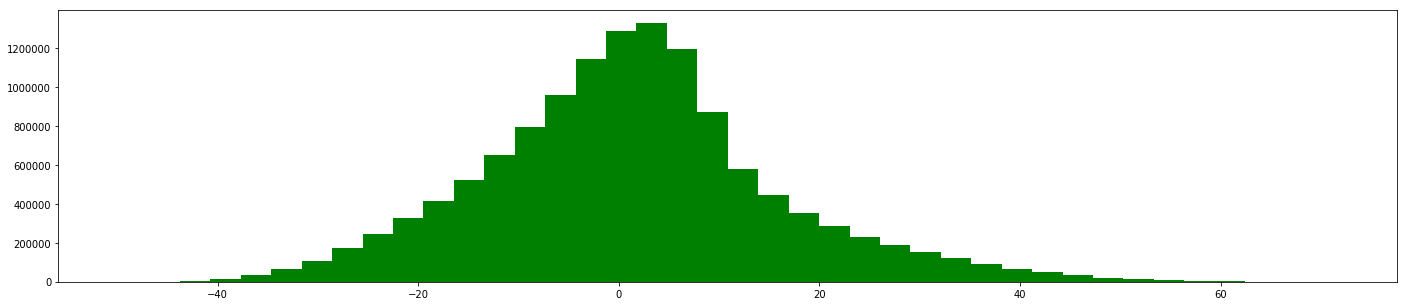

In [14]:
print(" MAX: ", Q_TABLE.max(), "\n","MIN: ", Q_TABLE.min(),"\n", "MEAN: ", Q_TABLE.mean(),"\n","STD: ",Q_TABLE.std())
num_bins = QUANTIZATION_LEVEL
fig = plt.figure(figsize=(24,5))
n, bins, patches = plt.hist(Q_TABLE.flatten(), num_bins, facecolor='green', alpha=1.0)
plt.show()

In [15]:
#TESTING
print("***MEASURING PERFORMANCE OF THE MODEL***")
results = np.empty(4)
LOCATION = 'aomori'
for YEAR in np.arange(2000,2019):
    capm      = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
    capm.eno  = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
    capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

    s, r, day_end, year_end = capm.reset()
    yr_test_record = np.empty(4)
    while True:
        # Get true values by denormalizing the state
        true_batt,  true_enp,  true_henergy,  true_fcast  = denormalize(s)
        # Get states
        batt_state, enp_state, henergy_state, fcast_state = discretize(true_batt, true_enp, true_henergy, true_fcast)
        # Choose action from Q_TABLE
        a = Q_TABLE[batt_state, enp_state, henergy_state, fcast_state,:].argmax()
        yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action
        # Execute Action
        s_, r, day_end, year_end = capm.step(a)
        if year_end:
            break
        s = s_

    yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage
    yr_test_reward_rec = yr_test_record[:,2]
    yr_test_reward_rec = yr_test_reward_rec[::24] #annual average reward
#     results = np.vstack((results, [int(YEAR), np.mean(yr_test_reward_rec), int(capm.violation_counter), int(capm.batt_violations)]))
#     print("\n")
    print("YEAR:", YEAR,end = '\t')
    print("Average Reward    : {:6.4}".format(np.mean(yr_test_reward_rec)),end='\t')
    print("Battery Violations: " , int(capm.batt_violations))

# # ###########################################################################################
# # ###########################################################################################
#     #     Plot the reward and battery for the entire year run
#     title = LOCATION.upper() + ',' + str(YEAR)
#     NO_OF_DAYS = capm.eno.NO_OF_DAYS

#     fig = plt.figure(figsize=(24,6))
#     fig.suptitle(title, fontsize=15)
    
# #     ax1 = fig.add_subplot(211)
# #     ax1.plot(yr_test_reward_rec)
# #     ax1.set_title("\n\nYear Run Reward")
# #     ax1.set_ylim([-3,3])
    
#     ax2 = fig.add_subplot(111)
#     ax2.plot(yr_test_record[:,0],'r')
#     ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BOPT/capm.BMAX, 'k--')
#     ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_LO/capm.BMAX, 'r:')
#     ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_HI/capm.BMAX, 'r:')
#     ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT+capm.ENP_MARGIN /2) /capm.BMAX, 'g:')
#     ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT-capm.ENP_MARGIN/2)/capm.BMAX, 'g:')
#     ax2.set_title("\n\nYear Run Battery")
#     ax2.set_ylim([0,1])
#     plt.sca(ax2)
#     plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))
#     fig.tight_layout()
#     plt.show()
# # ###########################################################################################
# # ###########################################################################################


***MEASURING PERFORMANCE OF THE MODEL***
YEAR: 2000	Average Reward    :  0.798	Battery Violations:  0
YEAR: 2001	Average Reward    : 0.5977	Battery Violations:  45
YEAR: 2002	Average Reward    : 0.7999	Battery Violations:  0
YEAR: 2003	Average Reward    : 0.7859	Battery Violations:  7
YEAR: 2004	Average Reward    :  0.894	Battery Violations:  0
YEAR: 2005	Average Reward    : 0.8979	Battery Violations:  0
YEAR: 2006	Average Reward    : 0.7375	Battery Violations:  0
YEAR: 2007	Average Reward    : 0.8106	Battery Violations:  0
YEAR: 2008	Average Reward    : 0.9247	Battery Violations:  0
YEAR: 2009	Average Reward    : 0.7905	Battery Violations:  0
YEAR: 2010	Average Reward    : 0.7929	Battery Violations:  2
YEAR: 2011	Average Reward    : 0.5912	Battery Violations:  32
YEAR: 2012	Average Reward    : 0.7166	Battery Violations:  0
YEAR: 2013	Average Reward    : 0.8386	Battery Violations:  0
YEAR: 2014	Average Reward    : 0.6971	Battery Violations:  21
YEAR: 2015	Average Reward    : 0.6866	Bat

In [16]:
LR                  = 1e-6          # learning rate
EPSILON             = 0.99
GAMMA               = 0.9           # reward discount
LAMBDA              = 0.95
NO_OF_ITERATIONS    = 100

In [17]:
random.seed(seed)
np.random.seed(seed)

In [18]:
#Tabular Training
results = np.empty(4)
for iteration in range(NO_OF_ITERATIONS):
    
    LOCATION    = 'aomori'#random.choice(['tokyo','wakkanai','minamidaito'])
    YEAR        = random.choice(np.arange(2000,2010))
    capm        = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
    capm.eno    = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
    capm.HMAX   = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

    s, r, day_end, year_end = capm.reset()
    yr_test_record = np.empty(4)
    experience_rec = np.empty(N_STATES * 2 + 2) #record all the transitions during training
    transition_rec = np.zeros((capm.eno.TIME_STEPS, N_STATES * 2 + 2)) #record all the transition in one day
    discrete_transition_rec = np.zeros((capm.eno.TIME_STEPS, N_STATES * 2 + 2)) #record all the transition in one day


    while True:
        # Get true values by denormalizing the state
        true_batt,  true_enp,  true_henergy,  true_fcast  = denormalize(s)
        # Get states
        batt_state, enp_state, henergy_state, fcast_state = discretize(true_batt, true_enp, true_henergy, true_fcast)
        this_state = tuple([batt_state, enp_state, henergy_state, fcast_state])

        # Choose action from Q_TABLE using e-greedy policy
        a = Q_TABLE[batt_state, enp_state, henergy_state, fcast_state,:].argmax()
        if np.random.uniform() > EPSILON:   # greedy
            a += np.random.randint(-3, 3)
        a = int(np.clip(a, 0, N_ACTIONS-1))
        
        yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action

        # Execute Action
        s_, r, day_end, year_end = capm.step(a)
        # Get next_state
        next_batt,  next_enp,  next_henergy,  next_fcast  = denormalize(s_)
        next_batt_state, next_enp_state, next_henergy_state, next_fcast_state = discretize(next_batt,  next_enp,  next_henergy,  next_fcast)
        next_state = tuple([next_batt_state, next_enp_state, next_henergy_state, next_fcast_state])
        
        #Remember experience
        transition_rec[capm.eno.hr-1,:] = np.hstack((stdize(s), [a, r], stdize(s_)))
        discrete_transition_rec[capm.eno.hr-1,:] = np.hstack((this_state, [a,r], next_state))
        
        if (day_end):
            transition_rec[:,5]  = r #broadcast reward to all states
            discrete_transition_rec[:,5]  = r 
            decay_factor         = [i for i in (LAMBDA**n for n in reversed(range(0, capm.eno.TIME_STEPS)))]
            transition_rec[:,5]  = transition_rec[:,5] * decay_factor #decay reward proportionately
            discrete_transition_rec[:,5]  = discrete_transition_rec[:,5] * decay_factor #decay reward proportionately
            experience_rec     = np.vstack((experience_rec, transition_rec))
          
            for i in np.arange(0,capm.eno.hr):
                b_this_state = tuple(discrete_transition_rec[i][0   :N_STATES].astype(int))
                b_a          = discrete_transition_rec[i][N_STATES  :N_STATES+1].astype(int)
                b_r          = discrete_transition_rec[i][N_STATES+1:N_STATES+2]
                b_next_state = tuple(discrete_transition_rec[i][-N_STATES:].astype(int))
                Q_TABLE[b_this_state][b_a] = Q_TABLE[b_this_state][b_a] + LR * (b_r + GAMMA * Q_TABLE[b_next_state].max() - Q_TABLE[b_this_state][b_a])
        
#         #Update Q-table
#         Q_TABLE[this_state][a] = Q_TABLE[this_state][a] + LR * (r + GAMMA * Q_TABLE[next_state].max() - Q_TABLE[this_state][a])
    
    
        if year_end:
            break
        s = s_
    
    experience_rec = np.delete(experience_rec, 0, 0)
    EXPERIENCE_FILENAME = './experience/'+'XP_'+str(QUANTIZATION_LEVEL)+'_'+ str(iteration)
#     np.save(EXPERIENCE_FILENAME, experience_rec)
    
    yr_test_record  = np.delete(yr_test_record,  0, 0) #remove the first row which is garbage
    yr_test_reward_rec = yr_test_record[:,2]
    yr_test_reward_rec = yr_test_reward_rec[::24] #annual average reward
#     print("\n")
    print("Iteration #", iteration, end="\t\t")
    print("YEAR:", YEAR, end="\t\t")
    print("Average Reward: {: 06.3f}".format(np.mean(yr_test_reward_rec)), end="\t\t")
    print("Battery Violations:" , int(capm.batt_violations))
    results = np.vstack((results, [int(YEAR), np.mean(yr_test_reward_rec), int(capm.violation_counter), int(capm.batt_violations)]))

#     # ###########################################################################################
#     # ###########################################################################################
#     #     Plot the reward and battery for the entire year run
#     title = LOCATION.upper() + ',' + str(YEAR)
#     NO_OF_DAYS = capm.eno.NO_OF_DAYS

#     fig = plt.figure(figsize=(24,3))
#     fig.suptitle(title, fontsize=15)

#     #     ax1 = fig.add_subplot(211)
#     #     ax1.plot(yr_test_reward_rec)
#     #     ax1.set_title("\n\nYear Run Reward")
#     #     ax1.set_ylim([-3,3])

#     ax2 = fig.add_subplot(111)
#     ax2.plot(yr_test_record[:,0],'r')
#     ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BOPT/capm.BMAX, 'k--')
#     ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_LO/capm.BMAX, 'r:')
#     ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_HI/capm.BMAX, 'r:')
#     ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT+capm.ENP_MARGIN /2) /capm.BMAX, 'g:')
#     ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT-capm.ENP_MARGIN/2)/capm.BMAX, 'g:')
#     ax2.set_title("\n\nYear Run Battery")
#     ax2.set_ylim([0,1])
#     plt.sca(ax2)
#     plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))
#     fig.tight_layout()
#     plt.show()
#     # ###########################################################################################
#     # ###########################################################################################
results = np.delete(results, 0, 0)
N_Q_TABLE = Q_TABLE

Iteration # 0		YEAR: 2009		Average Reward:  0.758		Battery Violations: 9
Iteration # 1		YEAR: 2002		Average Reward:  0.791		Battery Violations: 0
Iteration # 2		YEAR: 2003		Average Reward:  0.778		Battery Violations: 14
Iteration # 3		YEAR: 2006		Average Reward:  0.725		Battery Violations: 0
Iteration # 4		YEAR: 2008		Average Reward:  0.888		Battery Violations: 0
Iteration # 5		YEAR: 2003		Average Reward:  0.751		Battery Violations: 15
Iteration # 6		YEAR: 2004		Average Reward:  0.883		Battery Violations: 0
Iteration # 7		YEAR: 2007		Average Reward:  0.814		Battery Violations: 0
Iteration # 8		YEAR: 2006		Average Reward:  0.707		Battery Violations: 0
Iteration # 9		YEAR: 2005		Average Reward:  0.908		Battery Violations: 0
Iteration # 10		YEAR: 2000		Average Reward:  0.792		Battery Violations: 0
Iteration # 11		YEAR: 2004		Average Reward:  0.897		Battery Violations: 0
Iteration # 12		YEAR: 2004		Average Reward:  0.866		Battery Violations: 0
Iteration # 13		YEAR: 2003		Average Reward:  0

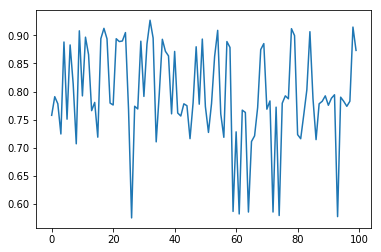

In [19]:
plt.plot(results[:,1])

In [20]:
#Validate
print("***MEASURING PERFORMANCE OF THE MODEL***")
results = np.empty(4)
LOCATION = 'aomori'
for YEAR in np.arange(2000,2019):
    capm      = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
    capm.eno  = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
    capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

    s, r, day_end, year_end = capm.reset()
    yr_test_record = np.empty(4)
    while True:
        # Get true values by denormalizing the state
        true_batt,  true_enp,  true_henergy,  true_fcast  = denormalize(s)
        # Get states
        batt_state, enp_state, henergy_state, fcast_state = discretize(true_batt, true_enp, true_henergy, true_fcast)
        # Choose action from Q_TABLE
        a = Q_TABLE[batt_state, enp_state, henergy_state, fcast_state,:].argmax()
        yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action
        # Execute Action
        s_, r, day_end, year_end = capm.step(a)
        if year_end:
            break
        s = s_

    yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage
    yr_test_reward_rec = yr_test_record[:,2]
    yr_test_reward_rec = yr_test_reward_rec[::24] #annual average reward
#     results = np.vstack((results, [int(YEAR), np.mean(yr_test_reward_rec), int(capm.violation_counter), int(capm.batt_violations)]))
#     print("\n")
    print("YEAR:", YEAR,end = '\t')
    print("Average Reward    : {:6.4}".format(np.mean(yr_test_reward_rec)),end='\t')
    print("Battery Violations: " , int(capm.batt_violations))

# # ###########################################################################################
# # ###########################################################################################
#     #     Plot the reward and battery for the entire year run
#     title = LOCATION.upper() + ',' + str(YEAR)
#     NO_OF_DAYS = capm.eno.NO_OF_DAYS

#     fig = plt.figure(figsize=(24,6))
#     fig.suptitle(title, fontsize=15)
    
# #     ax1 = fig.add_subplot(211)
# #     ax1.plot(yr_test_reward_rec)
# #     ax1.set_title("\n\nYear Run Reward")
# #     ax1.set_ylim([-3,3])
    
#     ax2 = fig.add_subplot(111)
#     ax2.plot(yr_test_record[:,0],'r')
#     ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BOPT/capm.BMAX, 'k--')
#     ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_LO/capm.BMAX, 'r:')
#     ax2.plot(np.ones_like(yr_test_record[:,0])*capm.BLIM_HI/capm.BMAX, 'r:')
#     ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT+capm.ENP_MARGIN /2) /capm.BMAX, 'g:')
#     ax2.plot(np.ones_like(yr_test_record[:,0])*(capm.BOPT-capm.ENP_MARGIN/2)/capm.BMAX, 'g:')
#     ax2.set_title("\n\nYear Run Battery")
#     ax2.set_ylim([0,1])
#     plt.sca(ax2)
#     plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))
#     fig.tight_layout()
#     plt.show()
# # ###########################################################################################
# # ###########################################################################################


***MEASURING PERFORMANCE OF THE MODEL***
YEAR: 2000	Average Reward    :  0.798	Battery Violations:  0
YEAR: 2001	Average Reward    : 0.5977	Battery Violations:  45
YEAR: 2002	Average Reward    : 0.7999	Battery Violations:  0
YEAR: 2003	Average Reward    : 0.7859	Battery Violations:  7
YEAR: 2004	Average Reward    :  0.894	Battery Violations:  0
YEAR: 2005	Average Reward    : 0.8979	Battery Violations:  0
YEAR: 2006	Average Reward    : 0.7375	Battery Violations:  0
YEAR: 2007	Average Reward    : 0.8106	Battery Violations:  0
YEAR: 2008	Average Reward    : 0.9247	Battery Violations:  0
YEAR: 2009	Average Reward    : 0.7905	Battery Violations:  0
YEAR: 2010	Average Reward    : 0.7929	Battery Violations:  2
YEAR: 2011	Average Reward    : 0.5912	Battery Violations:  32
YEAR: 2012	Average Reward    : 0.7166	Battery Violations:  0
YEAR: 2013	Average Reward    : 0.8386	Battery Violations:  0
YEAR: 2014	Average Reward    : 0.6971	Battery Violations:  21
YEAR: 2015	Average Reward    : 0.6866	Bat